# Exercise 08 RNN & NLP - Assignment

<span style="color:red">**The submission deadline of this assignment is February 23, 2025 at 23:59.**</span>

<span style="color:red">**In addition to the executed Jupyter Notebook, please also submit the saved `.pth` file of the trained CNN on Learn.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a text-classifier using LSTM.

The problem to be solved is to predict the class of a product based on the product page (title and description) on the E-commerce platform:

|Class|Example product page|
|-|-|
|Books|Inner Engineering: A Yogi's Guide to Joy About the Author Sadhguru Jaggi VasudevSADHGURU is a yogi, mystic, and visionary who established the Isha Foundation, a nonprofit dedicated to the cultivation of human potential...|
|Clothing & Accessories|Amour Butterfly Design Sunglasses For Girls 6+ Years { SKU16 } Amour Butterfly Design Sunglasses to give full protection. Very light weight. Highly durable. Its safe for kids eyes and give full eye protection against harmful uv rays...|
|Electronics|Bluetooth Dongle USB CSR 4.0 Adapter Receiver Transfer Wireless Adapter for PC Computer Laptop Supports Windows 10 8.1 8 7 Vista XP - Upgraded Version...|
|Household|Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch...|

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Create a LSTM-based text classifier
- Train the network,
- Reload the best model
- Evaluation using the test set
- Make predictions on unseen data

### Pre-configure

- Import necessary libraries
- Specify the computation device of PyTorch

In [1]:
# [TBC] complete your code here with proper comments
!pip install nltk

In [2]:
# import libraries
import os
import warnings
import datetime


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import classification_report

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# for padding a list of variable length tensors to equal length
from torch.nn.utils.rnn import pad_sequence
# for packing a tensor containing padded sequences of variable length
from torch.nn.utils.rnn import pack_padded_sequence

import nltk
# for removing stop words like 'the', 'and', etc
# stop words don't provide useful information
from nltk.corpus import stopwords
# for tokenization
from nltk.tokenize import word_tokenize

# for counting the number of unique tokens
from collections import Counter

In [6]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Task 1. Build the data pipeline

You are required to use `ecommerce_dataset.csv` which can be downloaded from the Learn Platform.

<span style="color:red">**[TBC]**</span> You need to:
- Load the dataset from the `ecommerce_dataset.csv` file
- Pre-process the text
    - Tokenization
    - Remove stop words (like 'and', 'the') that don't provide useful information
    - Remove non-alphabetic tokens
- Create the vocabulary
- Encode the tokens
- Create the Dataset and the Dataloader
    - Pad the tensors with variable lengths to equal length

In [8]:
# load dataset
df = pd.read_csv('ecommerce_dataset.csv')
df.head()

,text,label
0,Paper Plane Design Framed Wall Hanging Motivat...,3
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",3
2,SAF 'UV Textured Modern Art Print Framed' Pain...,3
3,"SAF Flower Print Framed Painting (Synthetic, 1...",3
4,Incredible Gifts India Wooden Happy Birthday U...,3


In [9]:
classes = ['Books', 'Clothing & Accessories', 'Electronics', 'Households']

In [10]:
# ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# set the stop words to the English mode
stop_words = set(stopwords.words('english'))

# define a function for pre-processing
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# apply preprocessing to the 'text' column
df['tokens'] = df['text'].apply(preprocess_text)

# show the first five rows
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,text,label,tokens
0,Paper Plane Design Framed Wall Hanging Motivat...,3,"[paper, plane, design, framed, wall, hanging, ..."
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",3,"[saf, framed, painting, wood, inch, x, inch, s..."
2,SAF 'UV Textured Modern Art Print Framed' Pain...,3,"[saf, textured, modern, art, print, framed, pa..."
3,"SAF Flower Print Framed Painting (Synthetic, 1...",3,"[saf, flower, print, framed, painting, synthet..."
4,Incredible Gifts India Wooden Happy Birthday U...,3,"[incredible, gifts, india, wooden, happy, birt..."


#### Create the vocabulary

In [11]:
# build vocabulary
all_tokens = [token for tokens in df['tokens'] for token in tokens]
token_counts = Counter(all_tokens)
print('The number of unique tokens in the vocabulary:', len(token_counts))

# keep the most common token
vocab_size = 20000
common_tokens = token_counts.most_common(vocab_size - 2)  # Reserve two spots for PAD and UNK tokens
print('The number of most common tokens preserved:', vocab_size)

# create token to index mapping
token_to_idx = {token: idx+2 for idx, (token, _) in enumerate(common_tokens)}
# '<PAD>' is used to represent padding tokens at the end of text
token_to_idx['<PAD>'] = 0
# '<UNK>' is used to represent unknown tokens that are not included in the vocabulary
token_to_idx['<UNK>'] = 1

# create index to token mapping
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

The number of unique tokens in the vocabulary: 60743
The number of most common tokens preserved: 20000


In [12]:
# define a function for encoding
def encode_tokens(tokens):
    return [token_to_idx.get(token, token_to_idx['<UNK>']) for token in tokens]

# apply the encoding function to the 'tokens' column
df['encoded_tokens'] = df['tokens'].apply(encode_tokens)

# show the first 5 rows
df.head()

,text,label,tokens,encoded_tokens
0,Paper Plane Design Framed Wall Hanging Motivat...,3,"[paper, plane, design, framed, wall, hanging, ...","[248, 3358, 14, 5264, 76, 552, 5036, 158, 321,..."
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",3,"[saf, framed, painting, wood, inch, x, inch, s...","[8132, 5264, 1375, 209, 99, 3, 99, 249, 835, 8..."
2,SAF 'UV Textured Modern Art Print Framed' Pain...,3,"[saf, textured, modern, art, print, framed, pa...","[8132, 2757, 216, 301, 267, 5264, 1375, 2646, ..."
3,"SAF Flower Print Framed Painting (Synthetic, 1...",3,"[saf, flower, print, framed, painting, synthet...","[8132, 902, 267, 5264, 1375, 2646, 99, 3, 99, ..."
4,Incredible Gifts India Wooden Happy Birthday U...,3,"[incredible, gifts, india, wooden, happy, birt...","[1658, 1196, 49, 275, 1209, 1718, 155, 4870, 2..."


In [13]:
# define a custom Dataset class to store the data as tensors
class AGNewsDataset(Dataset):
    def __init__(self, encoded_tokens_list, labels):
        self.encoded_tokens_list = encoded_tokens_list
        self.labels = labels

    def __len__(self):
        return len(self.encoded_tokens_list)

    def __getitem__(self, idx):
        X = self.encoded_tokens_list[idx]
        y = self.labels[idx]
        X = torch.tensor(X, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.long)
        return X, y

In [14]:
# create the training, test and validation dataset
ds = AGNewsDataset(df['encoded_tokens'].values, df['label'].values)
train_val_ds, test_ds = random_split(ds, [0.7, 0.3])
train_ds, val_ds = random_split(train_val_ds, [0.8, 0.2])

In [15]:
# define a collate function to pad the sequences in the same batch to equal length
# in addition to the padded_X and y, also return the length of X before padding
def collate_batch(batch):
    batch_X, batch_y, batch_length = [], [], []
    for (X, y) in batch:
        batch_X.append(X)
        batch_y.append(y)
        batch_length.append(len(X))
    batch_length = torch.tensor(batch_length, dtype=torch.int64)
    batch_y = torch.tensor(batch_y, dtype=torch.int64)
    # pad sequences to equal length
    batch_X = pad_sequence(batch_X, batch_first = True)
    return batch_X, batch_y, batch_length

In [16]:
# create the training, validation, and test data loaders
batch_size = 128 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True, collate_fn = collate_batch)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False, collate_fn = collate_batch)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False, collate_fn = collate_batch)

In [17]:
# get one batch and print its shape
for batch in test_dl:
    print(batch[0].shape)
    print(batch[1].shape)
    print(batch[2].shape)
    break

torch.Size([128, 324])
torch.Size([128])
torch.Size([128])


## Task 2. Create a CNN-based image classifier

<span style="color:red">**[TBC]**</span> You need to:
- Define a custom class to specify the structure and the forward method of the network
    - You are required to use `nn.LSTM()` layer in the network
- Create an instance of the network and move it to the computation device

In [18]:
# define a custom neural network class
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_class, num_layers, dropout):
        super().__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # Stacked LSTM layers
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)

        # Additional Fully Connected layers
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Bidirectional LSTM outputs 2 * hidden_size
        self.fc2 = nn.Linear(hidden_size, num_class)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        x = self.embedding(x)  # Embedding layer

        # Packing the sequences for efficient processing
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # LSTM layers
        out, (h, c) = self.lstm(packed_x)

        # Concatenating the last hidden state from both directions (bidirectional LSTM)
        h = torch.cat((h[-2], h[-1]), dim=1)

        # Fully connected layers
        x = self.fc1(h)
        x = F.relu(x)  # Activation function
        x = self.dropout(x)
        x = self.fc2(x)  # Output layer

        return x

Changes:

  •	Bidirectional LSTM: Helps the model understand both past and future context.

  •	Stacked LSTMs (num_layers=2): Allows deeper feature extraction.

  •	Dropout (dropout=0.5): Helps prevent overfitting.

  •	Extra FC layers (fc1 → fc2): Helps in feature transformation before the final output.

In [19]:
# create the neural network
embed_size = 128
hidden_size = 128
num_layers = 2
dropout = 0.2
num_class = 4
model = LSTMClassifier(vocab_size, embed_size, hidden_size, num_class,num_layers,dropout)
model = model.to(device)

Changes:

1. Embedding Size (embed_size = 128)

	  A higher embedding size allows the model to capture more semantic meaning from words.

2. Hidden Size (hidden_size = 128)

	  Increasing it to 128 will help capture more sequence dependencies.

3. Batch Size (batch_size = 128)

	  Reducing it to 128 ensures more stable training while avoiding memory bottlenecks.

4. Dropout (dropout = 0.5)
  
    Helps prevent overfitting given the deeper architecture.

## Task 3. Train the network

<span style="color:red">**[TBC]**</span> You need to:
- Define a `train()` function
- Specify the training hyper-parameters
- Train the network
- Plot the loss history of the training process

In [20]:
# define the training function
def train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
):
    # initialization
    min_val_loss = np.inf
    patience_counter = 0
    histories = {
        'train_batch': [],
        'train_epoch': [],
        'val_batch': [],
        'val_epoch': []
    }
    saved_path = ''
    start_time = datetime.datetime.now()

    # start training
    for epoch in range(epochs):
        # train set
        train_epoch_loss = 0.0
        model.train()
        for X, y, lens in tqdm(train_dl, desc = f'Training batch\t'): # tqdm progress bar
            X, y, lens = X.to(device), y.to(device), lens.to(device)
            logits = model(X, lens)
            train_batch_loss = loss_fn(logits, y)
            train_batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            histories['train_batch'].append(train_batch_loss.item())
            train_epoch_loss += train_batch_loss.item()
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)

        # validation set
        val_epoch_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X, y, lens in tqdm(val_dl, desc = f'Validation batch'): # tqdm progress bar
                X, y, lens = X.to(device), y.to(device), lens.to(device)
                logits = model(X, lens)
                val_batch_loss = loss_fn(logits, y)
                histories['val_batch'].append(val_batch_loss.item())
                val_epoch_loss += val_batch_loss.item()
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if current_lr != new_lr:
            print(f'Learning rate reduced after epoch {epoch+1}\n')

        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss = val_epoch_loss
            patience_counter = 0
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = saved_path_prefix + f'_epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}\n')
        else:
            patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print('Early stopping!')
            break
    return histories, saved_path

In [21]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
weight_decay = 1e-5
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 100
early_stopping_patience = 10
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 5
)
saved_path_prefix = 'ag_news_classifier'

Changes:

1. Learning Rate

0.1 is too high for deep LSTMs, likely leading to instability

2. Optimizer

Adam is better for NLp an works well with LSTMs

3. Epochs

100 is more practical with early stopping

4. Scheduler

Keeps learning rate adaptive to loss improvement



In [22]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

Validation batch: 100%|██████████| 56/56 [00:01<00:00, 37.62it/s]


Epoch 1: train loss = 0.475337, val loss = 0.224989, time consumed = 0:00:19
Model saved after epoch 1



Validation batch: 100%|██████████| 56/56 [00:01<00:00, 36.41it/s]


Epoch 2: train loss = 0.160558, val loss = 0.167548, time consumed = 0:00:39
Model saved after epoch 2



Validation batch: 100%|██████████| 56/56 [00:01<00:00, 37.98it/s]


Epoch 3: train loss = 0.099154, val loss = 0.159955, time consumed = 0:00:58
Model saved after epoch 3



Validation batch: 100%|██████████| 56/56 [00:01<00:00, 34.16it/s]


Epoch 4: train loss = 0.066479, val loss = 0.154370, time consumed = 0:01:16
Model saved after epoch 4



Validation batch: 100%|██████████| 56/56 [00:01<00:00, 37.81it/s]


Epoch 5: train loss = 0.048835, val loss = 0.154432, time consumed = 0:01:34


Validation batch: 100%|██████████| 56/56 [00:01<00:00, 38.40it/s]


Epoch 6: train loss = 0.032677, val loss = 0.170795, time consumed = 0:01:52


Validation batch: 100%|██████████| 56/56 [00:01<00:00, 37.01it/s]


Epoch 7: train loss = 0.026248, val loss = 0.171325, time consumed = 0:02:11


Validation batch: 100%|██████████| 56/56 [00:01<00:00, 36.13it/s]


Epoch 8: train loss = 0.020330, val loss = 0.192514, time consumed = 0:02:29


Validation batch: 100%|██████████| 56/56 [00:01<00:00, 38.00it/s]


Epoch 9: train loss = 0.014338, val loss = 0.196483, time consumed = 0:02:47


Validation batch: 100%|██████████| 56/56 [00:01<00:00, 38.52it/s]


Epoch 10: train loss = 0.017211, val loss = 0.203216, time consumed = 0:03:05
Learning rate reduced after epoch 10



Validation batch: 100%|██████████| 56/56 [00:01<00:00, 37.82it/s]


Epoch 11: train loss = 0.007461, val loss = 0.188457, time consumed = 0:03:24


Validation batch: 100%|██████████| 56/56 [00:01<00:00, 37.55it/s]


Epoch 12: train loss = 0.003445, val loss = 0.194402, time consumed = 0:03:42


Validation batch: 100%|██████████| 56/56 [00:01<00:00, 38.23it/s]


Epoch 13: train loss = 0.002601, val loss = 0.198662, time consumed = 0:04:01


Validation batch: 100%|██████████| 56/56 [00:01<00:00, 35.75it/s]

Epoch 14: train loss = 0.002176, val loss = 0.204101, time consumed = 0:04:19
Early stopping!


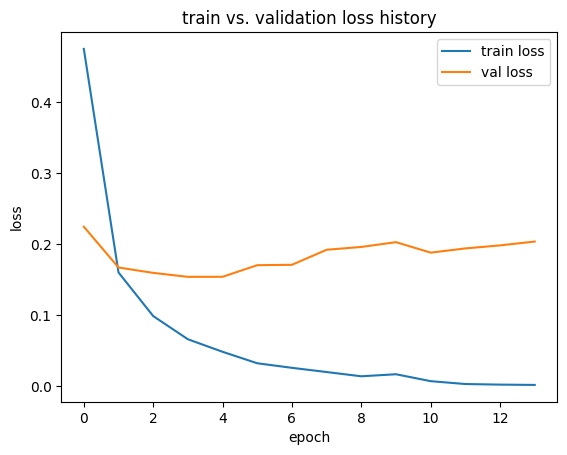

In [23]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Task 4. Reload the best model

<span style="color:red">**[TBC]**</span> You need to:
- Reload the best trained model saved during the training process
- Move the reloaded model to the computation device

In [24]:
# reload the best model
model.load_state_dict(torch.load(saved_path))
model.to(device)

<ipython-input-24-70a5ae9610de>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(saved_path))


LSTMClassifier(
  (embedding): Embedding(20000, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Task 5. Test and evaluation

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
    - Output logits, probabilities and predictions
    - Output the loss value on the test set
- Make predictions on the test dataset
- Evaluate the performance
    - Use `sklearn.metrics.classification_report()`

In [25]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    logits, probs, preds = [], [], []
    with torch.no_grad():
        loss = 0.0
        for (X, y, lens) in dataloader:
            X, y, lens = X.to(device), y.to(device), lens.to(device)
            batch_logits = model(X, lens)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()

            batch_probs = torch.softmax(batch_logits, dim = -1)
            _, batch_preds = torch.max(batch_logits, 1)

            logits.append(batch_logits.cpu().numpy())
            probs.append(batch_probs.cpu().numpy())
            preds.append(batch_preds.cpu().numpy())
        loss /= len(dataloader)
        print(f"test loss = {loss}")
    return np.concatenate(logits), np.concatenate(probs), np.concatenate(preds), loss

In [26]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, model, loss_fn)

# obtain test labels
test_label = []
for (_, y, _) in test_dl:
    test_label.extend(y.cpu().numpy())

print(classification_report(test_label, test_pred, target_names = classes))

test loss = 0.14906704203546547
                        precision    recall  f1-score   support

                 Books       0.97      0.95      0.96      3534
Clothing & Accessories       0.98      0.97      0.97      2572
           Electronics       0.94      0.95      0.95      3214
            Households       0.95      0.97      0.96      5806

              accuracy                           0.96     15126
             macro avg       0.96      0.96      0.96     15126
          weighted avg       0.96      0.96      0.96     15126



## Task 6. Make predictions on unseen text

<span style="color:red">**[TBC]**</span> You need to:
- Define a `predict_text()` function
- Specify an unseen product page by yourself
    - Use a real product page on the ecommerce platform as Amazon
    - Or make up a fake one yourself
- Make predictions and display the results

In [27]:
# define a function to predict the classes of a list of text
def predict_text(model, text_list):
    X, lens = [], []
    for text in text_list:
        tokens = preprocess_text(text)
        encoded_tokens = encode_tokens(tokens)
        X.append(torch.tensor(encoded_tokens, dtype=torch.int64))
        lens.append(len(encoded_tokens))
    X = pad_sequence(X, batch_first=True)
    lens = torch.tensor(lens, dtype=torch.int64)
    with torch.no_grad():
        logits = model(X.to(device), lens.to(device))
        _, preds = torch.max(logits, 1)
    return preds.cpu().numpy()

In [28]:
# example texts
text_list = [
    "The Subtle Art of Not Giving a Fck: A Counterintuitive Approach to Living a Good Life. Mark Manson provides a refreshing take on personal development, arguing that embracing life’s struggles is more valuable than trying to be constantly positive. With humor and raw honesty, this book teaches readers how to focus on what truly matters in life.",
    "Designed for both casual and professional runners, these Nike Air Zoom shoes provide superior comfort, lightweight cushioning, and breathability. Made with high-quality synthetic material, they offer excellent grip and stability for long-distance running.",
    "Experience industry-leading noise cancellation with Sony’s WH-1000XM4 headphones. Featuring dual noise sensor technology, touch controls, and up to 30 hours of battery life, these headphones provide an immersive sound experience with deep bass and crystal-clear highs",
    "Made from 100% premium Egyptian cotton, this ultra-soft towel set includes two bath towels, two hand towels, and two face towels. Designed for luxury and durability, these towels offer maximum absorbency while maintaining a plush feel after every wash"
]
# make prediction
preds = predict_text(model, text_list)
# print results
for idx in range(len(text_list)):
    text = text_list[idx]
    pred = preds[idx]
    print(f'Text: {text}\nPredicted category: {classes[pred]}\n')

Text: The Subtle Art of Not Giving a Fck: A Counterintuitive Approach to Living a Good Life. Mark Manson provides a refreshing take on personal development, arguing that embracing life’s struggles is more valuable than trying to be constantly positive. With humor and raw honesty, this book teaches readers how to focus on what truly matters in life.
Predicted category: Books

Text: Designed for both casual and professional runners, these Nike Air Zoom shoes provide superior comfort, lightweight cushioning, and breathability. Made with high-quality synthetic material, they offer excellent grip and stability for long-distance running.
Predicted category: Households

Text: Experience industry-leading noise cancellation with Sony’s WH-1000XM4 headphones. Featuring dual noise sensor technology, touch controls, and up to 30 hours of battery life, these headphones provide an immersive sound experience with deep bass and crystal-clear highs
Predicted category: Electronics

Text: Made from 100% 